# The Transfer Velocity of Money

In [1]:
import numpy as np
import pandas as pd
import json
import re
import os
import math
import random 

## Descriptives
### Directory paths

In [2]:
# Define directories
homedir = os.path.expanduser("~")
projdir = os.path.join(homedir,'Documents','Research','Sarafu')
datadir = os.path.join(projdir,'Sarafu2021_UKDS')

##### Load into pandas


In [3]:
# Transaction data
dtypes = {}
dtypes['id'] = 'int'
dtypes['transfer_subtype'] = 'category'
dtypes['source'] = 'string'
dtypes['target'] = 'string'
dtypes['weight'] = 'float'

txns_fn = os.path.join(datadir,"transactions","sarafu_txns.csv")
txns = pd.read_csv(txns_fn,dtype=dtypes,parse_dates=['timeset'])

In [4]:
# Duration data
dtypes = {}
dtypes['duration'] = 'float'
dtypes['amount'] = 'float'
dtypes['fraction'] = 'float'
dtypes['motif'] = 'category'
dtypes['categ'] = 'category'
dtypes['account'] = 'string'
dtypes['timestamp_beg'] = 'string'
dtypes['timestamp_end'] = 'string'

# Upper and lower bounds for durations where the size dipped below 0.01 Sarafu 
durations = {}
for bound in ["min","max"]:
    # Define filename
    durations_fn = os.path.join(datadir,'durations',"sarafu_durations_"+bound+".csv")
    # Load dataset
    durations[bound] = pd.read_csv(durations_fn,dtype=dtypes,parse_dates=['timestamp_beg','timestamp_end'])

##### Account features

In [5]:
from pandas.api.types import CategoricalDtype

In [6]:
# User data
categoricals = ['gender','area_name','area_type','held_roles','business_type']
strings = ['start','old_POA_blockchain_address','xDAI_blockchain_address']
dtypes = {col:"category" for col in categoricals}
dtypes.update({col:"string" for col in strings})

users_fn = os.path.join(datadir,"sarafu_xdai","sarafu_users_20210615.csv")
users = pd.read_csv(users_fn,dtype=dtypes,na_filter=False)
users = users.drop_duplicates(subset=['xDAI_blockchain_address'],keep='first')
users = users.set_index('xDAI_blockchain_address')

In [7]:
# Denote the VENDOR as a 'system' account, since they were used to facilitate pandemic aid
users.loc["0x56661cAb9a961a26F506a013C28e2528670D5fD3","business_type"] = 'system'

In [8]:
# Group areas together
area_mapping = {value:value for value in users['area_name'].unique()}
area_mapping.update({'Nyanza':'Other Rural', 'Turkana':'Other Rural', 'Misc Rural Counties':'Other Rural', 'Kisauni Mombasa':'Mombasa', 'Misc Mombasa':'Mombasa', 'Kilifi':'Kilifi', 'Mukuru Nairobi':'Nairobi', 'Misc Nairobi': 'Nairobi', 'other': 'Other Rural', 'none': 'none'})
area_cat = CategoricalDtype(categories=list(reversed(['Nairobi', 'Kinango Kwale', 'Other Rural', 'Mombasa', 'Kilifi'])), ordered=True)
# Update the variable
users['area_name'] = users['area_name'].astype("category").map(area_mapping).astype(area_cat)

In [9]:
# Also in the urban/rural feature, 'other' referrs to unknown
type_mapping = {value:value for value in users['area_type'].unique()}
type_mapping.update({'other': 'unknown'})
type_cat = CategoricalDtype(categories=["rural", "urban", "periurban", "unknown"], ordered=True)
# Update the variable
users['area_type'] = users['area_type'].astype("category").map(type_mapping).astype(type_cat)

In [10]:
# Group reported livelihoods
bus_mapping = {value:value for value in users['business_type'].unique()}
bus_mapping.update({'other':'unknown','fuel/energy':'fuel/water','water':'fuel/water','transport':'services',
               'education':'services','health':'services','environment':'services',
               'government':'services','faith':'services'})
bus_cat = CategoricalDtype(categories=["unknown","fuel/water","services","shop","farming","labour","food","savings","system"], ordered=True)
# Update the variable
users['business_type'] = users['business_type'].astype("category").map(bus_mapping).astype(bus_cat)

In [11]:
mapping = {}
# attributes mapped to the SENDER of the transaction
for attr in ['area_name','area_type','business_type']:
    mapping[attr] = dict(users[attr])
    txns[attr] = txns['source'].map(mapping[attr])

### Temporal aggregation

In [12]:
from datetime import datetime, timedelta
import calendar

##### Timestamps

In [13]:
# Months
txns['Month'] = txns['timeset'].dt.strftime("%b %y")
month_cat = CategoricalDtype(categories=reversed(['Jan 20','Feb 20','Mar 20','Apr 20','May 20','Jun 20',
                                        'Jul 20','Aug 20','Sep 20','Oct 20','Nov 20','Dec 20',
                                        'Jan 21','Feb 21','Mar 21','Apr 21','May 21','Jun 21']),ordered=True)
txns['Month'] = txns['Month'].astype(month_cat)
# Weeks
txns['Week'] = txns['timeset'].dt.strftime("%Y-%U")
txns.loc[txns['Week']=='2021-00','Week'] = '2020-52' # correct for the split week at the year-shift
txns['Week'] = txns['Week'].astype('category')
# Hours
txns['Hour'] = txns['timeset'].dt.strftime("%Y-%m-%d %H")
txns['Hour'] = txns['Hour'].astype('string')

##### Timeseries

In [14]:
t_min = txns.loc[0,"timeset"].replace(second=0, microsecond=0, minute=0)
t_max = txns.loc[len(txns["timeset"])-1,"timeset"].replace(second=0, microsecond=0, minute=0)

In [15]:
hourly = pd.DataFrame({"hour":pd.date_range(t_min,t_max,freq='H')})
hourly["Hour"] = hourly['hour'].dt.strftime("%Y-%m-%d %H")
# Hours
hourly = hourly.set_index("Hour")
# Months
hourly['Month'] = hourly['hour'].dt.strftime("%b %y")
hourly['Month'] = hourly['Month'].astype(month_cat)
# Weeks
hourly['Week'] = hourly['hour'].dt.strftime("%Y-%U")
hourly.loc[hourly['Week']=='2021-00','Week'] = '2020-52' # correct for the split week at the year-shift
hourly['Week'] = hourly['Week'].astype('category')

### Sarafu hourly balance
Total balance not including that held by "system" accounts

In [16]:
# Note the "system" accounts
system_accts = users[users["business_type"]=='system'].index.to_list()
# Remove the ADMINs; these don't have a balance
system_accts.remove("0xBDB3Bc887C3b70586BC25D04d89eC802b897fC5F")
system_accts.remove("0xEDA5C9B75Fdb3B9bdAB987A704632280Cf93084F")

In [17]:
# Creation and dissolution of currency
curr_up_adm = txns[txns["transfer_subtype"].isin(["DISBURSEMENT"])].copy()
curr_dn_adm = txns[txns["transfer_subtype"].isin(["RECLAMATION"])].copy()

# Remove transactions with system accounts
curr_up_adm = curr_up_adm[~curr_up_adm['target'].isin(system_accts)]
curr_dn_adm = curr_dn_adm[~curr_dn_adm['source'].isin(system_accts)]

# Flip the sign of transactions dissolving currency
curr_dn_adm["weight"] = -1*curr_dn_adm["weight"]

In [18]:
# All transfers
trfs = txns[txns["transfer_subtype"].isin(["STANDARD","AGENT_OUT"])].copy()

# Transfers into and out of system accounts
curr_up_sys = trfs[trfs["source"].isin(system_accts)].copy()
curr_dn_sys = trfs[trfs["target"].isin(system_accts)].copy()

# Remove transactions with (other) system accounts
curr_up_sys = curr_up_sys[~curr_up_sys['target'].isin(system_accts)]
curr_dn_sys = curr_dn_sys[~curr_dn_sys['source'].isin(system_accts)]

# Flip the sign of transactions removing currency
curr_dn_sys["weight"] = -1*curr_dn_sys["weight"]

In [19]:
# Combine the dataframes
txns_bal = pd.concat([curr_up_adm,curr_dn_adm,curr_up_sys,curr_dn_sys])

# For transactions raising the balance of user accounts, the relevant attribute is that of the RECIPIENT
for attr in ['area_name','area_type','business_type']:
    txns_bal.loc[txns_bal["weight"]>0,attr] = txns_bal.loc[txns_bal["weight"]>0,'target'].map(mapping[attr])

In [20]:
# Get the cumulative balance
hourly["change"] = txns_bal[["Hour","weight"]].groupby(['Hour']).sum()
hourly.loc[hourly["change"].isna(),'change'] = 0
hourly["balance"] = hourly["change"].cumsum()

### Sarafu transaction volume

In [21]:
# all transfers
trfs = txns[txns["transfer_subtype"].isin(["STANDARD","AGENT_OUT"])].copy()
# drop transfers from the 'system' accounts
trfs_sys = trfs[trfs['business_type']=='system'].index
trfs = trfs.drop(trfs_sys)

In [22]:
total = {}
total["Total"] = 'all'
total["volume"] = pd.Series(trfs["weight"].sum())
total["balance_avg"] = pd.Series(hourly["balance"].mean())
total["hours"] = pd.Series(hourly["balance"].count())
total["weeks"] = total["hours"]/24/7
total = pd.DataFrame(total)

In [23]:
weekly = trfs[["Week","weight"]].groupby(['Week']).sum()
weekly['volume'] =  weekly['weight']
del weekly['weight']
weekly["balance_avg"] = hourly[["Week","balance"]].groupby(['Week']).mean()
weekly["hours"] = hourly[["Week","balance"]].groupby(['Week']).count()
weekly["weeks"] = weekly["hours"]/24/7
weekly = weekly.reset_index()
weekly["week"] = weekly["Week"].apply(lambda x: datetime.strptime(x+"-0","%Y-%U-%w"))

In [24]:
monthly = trfs[["Month","weight"]].groupby(['Month']).sum()
monthly['volume'] = monthly['weight']
del monthly['weight']
monthly["balance_avg"] = hourly[["Month","balance"]].groupby(['Month']).mean()
monthly = monthly.reindex(index=monthly.index[::-1])
monthly["days"] = [7,29,31,30,31,30,31,31,30,31,30,31,31,28,31,30,31,15]
monthly["weeks"] = monthly["days"]/7
monthly = monthly.reset_index()
monthly["month"] = pd.to_datetime(monthly["Month"],format="%b %y")+timedelta(days=15)

##### Interpretable index

In [25]:
total = total.set_index('Total')
weekly = weekly.set_index('Week', drop=False)
monthly = monthly.set_index('Month', drop=False)

### Velocity conventional estimation

In [26]:
total["velocity_cnv"] = total["volume"]/total["balance_avg"]/total["hours"]*7*24
total["velocity_cnv"]

Total
all    0.308596
Name: velocity_cnv, dtype: float64

In [27]:
weekly["velocity_cnv"] = weekly["volume"]/weekly["balance_avg"]

In [28]:
monthly["velocity_cnv"] = monthly["volume"]/monthly["balance_avg"]/monthly["days"]*7

## Inverse estimation 
### Velocity & effective balance

##### Timestamps & temporal aggregation

In [29]:
# Each holding time is observed WHEN IT ENDS
for bound in ["min","max"]:
    durations[bound]['Month'] = durations[bound]['timestamp_end'].dt.strftime("%b %y")
    # order neatly
    category = CategoricalDtype(categories=reversed(['Jan 20','Feb 20','Mar 20','Apr 20','May 20','Jun 20',
                                            'Jul 20','Aug 20','Sep 20','Oct 20','Nov 20','Dec 20',
                                            'Jan 21','Feb 21','Mar 21','Apr 21','May 21','Jun 21']),ordered=True)
    durations[bound]['Month'] = durations[bound]['Month'].astype(category)
    # define values
    durations[bound]['Week'] = durations[bound]['timestamp_end'].dt.strftime("%Y-%U")
    durations[bound]['Week'] = durations[bound]['Week'].astype('category')
    # funds withdrawn at the end of the timewindow are dropped because they not actually observed (~final)
    indefinites = durations[bound][durations[bound]['motif'].str.contains("~final")].index
    durations[bound] = durations[bound].drop(indefinites)

##### Account features

In [30]:
# attributes mapped to the HOLDER of the Sarafu for this duration
for bound in ["min","max"]:
    for attr in ['area_name','area_type','business_type']:
        durations[bound][attr] = durations[bound]['account'].map(mapping[attr])
    durations[bound] = durations[bound].drop(columns=['account'])

In [31]:
# Update the user categoricals, as done for users
for bound in ["min","max"]:
    durations[bound]['area_name'] = durations[bound]['area_name'].astype(area_cat)
    durations[bound]['area_type'] = durations[bound]['area_type'].astype(type_cat)
    durations[bound]['business_type'] = durations[bound]['business_type'].astype(bus_cat)

In [32]:
# drop durations from the 'system' accounts
for bound in ["min","max"]:
    system_durs = durations[bound][durations[bound]['business_type']=='system'].index
    durations[bound] = durations[bound].drop(system_durs)

##### Imprecision & type of user activity

In [33]:
# Note the type of transaction that ended the held duration
for bound in ["min","max"]:
    durations[bound]['Type'] = durations[bound]['motif'].apply(lambda motif: motif.split('~')[1])
    # Exit type
    category = CategoricalDtype(categories=["AGENT_OUT","RECLAMATION","STANDARD"],ordered=True)
    durations[bound]['Type'] = durations[bound]['Type'].astype(category)

In [34]:
# Flag the precision of the duration -- bit different per bound
for bound in ["min","max"]:
    # Most durations are exatly observed
    durations[bound]['Precision'] = "Observed"
    # Durations are not observed below a certain size (0.1 Sarafu, in our case)
    if bound=="max":
        durations[bound].loc[durations[bound]['categ'].str.contains("existing~"),'Precision'] = "Upper bound"
    if bound=="min":
        durations[bound].loc[durations[bound]['categ'].str.contains("~untracked"),'Precision'] = "Lower bound"
    # Order neatly
    category = CategoricalDtype(categories=["Lower bound","Upper bound","Observed"],ordered=True)
    durations[bound]['Precision'] = durations[bound]['Precision'].astype(category)
    durations[bound]['Precision'] = durations[bound]['Precision'].cat.remove_unused_categories()
    # Output the precision
    print(bound,"\n",durations[bound]['Precision'].value_counts(),"\n")

min 
 Observed       11764396
Lower bound      311064
Name: Precision, dtype: int64 

max 
 Observed       11764396
Upper bound       31588
Name: Precision, dtype: int64 



#### Weighted average held duration

In [35]:
# Durations for transfers (i.e. funds making up the transaction volume, entering or remaining in circulation)
durations_trfs = {}
for bound in ["min","max"]:
    durations_trfs[bound] = durations[bound][durations[bound]['Type'].isin(["AGENT_OUT","STANDARD"])].copy()

In [36]:
def avg_duration(mixed_durs_df):
    try:
        # average observed held duration, in weeks, weighted by the amount
        return np.average(mixed_durs_df["duration"], weights=mixed_durs_df["amount"])/24/7
    except:
        return np.nan

In [37]:
# Compute the average held duration
for bound in ["min","max"]:
    total['duration_avg_'+bound] = avg_duration(durations_trfs[bound])
    weekly['duration_avg_'+bound] = durations_trfs[bound].groupby(['Week']).apply(avg_duration).to_frame(name='duration_avg')
    monthly['duration_avg_'+bound] = durations_trfs[bound].groupby(['Month']).apply(avg_duration).to_frame(name='duration_avg')
    print("duration_avg",bound,total['duration_avg_'+bound]["all"])

duration_avg min 1.3602613358726798
duration_avg max 1.3603431530947723


In [38]:
# Compute the inverse-derived velocity
for bound in ["min","max"]:
    total['velocity_inv_'+bound] = total['duration_avg_'+bound]**(-1)
    weekly['velocity_inv_'+bound] = weekly['duration_avg_'+bound]**(-1)
    monthly['velocity_inv_'+bound] = monthly['duration_avg_'+bound]**(-1)
    print("velocity_inv",bound,total["velocity_inv_"+bound]["all"])

velocity_inv min 0.7351528516088027
velocity_inv max 0.7351086361738993


In [39]:
# Compute the effective balance
for bound in ["min","max"]:
    total['balance_eff_'+bound] = total['volume']/(total['velocity_inv_'+bound]*total['weeks'])
    weekly['balance_eff_'+bound] = weekly['volume']/(weekly['velocity_inv_'+bound]*weekly['weeks'])
    monthly['balance_eff_'+bound] = monthly['volume']/(monthly['velocity_inv_'+bound]*monthly['weeks'])
    print("balance_eff",bound,total["balance_eff_"+bound]["all"])

balance_eff min 5686646.08619537
balance_eff max 5686988.127517522


In [40]:
# Compute the effective balance, as a fraction of the average balance
for bound in ["min","max"]:
    total['balance_frc_'+bound] = total['balance_eff_'+bound]/total['balance_avg']
    weekly['balance_frc_'+bound] = weekly['balance_eff_'+bound]/weekly['balance_avg']
    monthly['balance_frc_'+bound] = monthly['balance_eff_'+bound]/monthly['balance_avg']
    print("balance_frc",bound,total["balance_frc_"+bound]["all"])

balance_frc min 0.4197713603378883
balance_frc max 0.41979660881456776


#### Subgroup analysis

In [41]:
def subgroup_analysis(column, value, suffix, total, weekly, monthly):
    # Dataframes
    trfs_df = trfs[trfs[column]==value]
    curr_df = txns_bal[txns_bal[column]==value]
    # Labels
    label_F  = 'volume'+suffix
    label_B  = 'balance'+suffix
    label_v  = 'velocity_cnv'+suffix
    # Add a row to the total dataframe (CANNOT seem to do this with concat!)
    total = total.append(pd.Series(dtype='float64').rename(value))
    total.loc[value,'weeks'] = total.loc['all','weeks']
    total.loc[value,'hours'] = total.loc['all','hours']
    # Tabulate the transaction volume
    total.loc[value,'volume'] = trfs_df["weight"].sum()
    weekly[label_F] = trfs_df[["Week","weight"]].groupby(['Week']).sum()
    monthly[label_F] = trfs_df[["Month","weight"]].groupby(['Month']).sum()
    # Compute the average balance
    hourly[label_B.replace('balance','change')] = curr_df[["Hour","weight"]].groupby(['Hour']).sum()
    hourly.loc[hourly[label_B.replace('balance','change')].isna(),label_B.replace('balance','change')] = 0
    hourly[label_B] = hourly[label_B.replace('balance','change')].cumsum()
    total.loc[value,'balance_avg'] = hourly[label_B].mean()
    weekly[label_B.replace('balance','balance_avg')] = hourly[["Week",label_B]].groupby(['Week']).mean()
    monthly[label_B.replace('balance','balance_avg')] = hourly[["Month",label_B]].groupby(['Month']).mean()
    # Compute the conventional velocity
    total.loc[value,'velocity_cnv'] = total.loc[value,'volume']/total.loc[value,'balance_avg']
    weekly[label_v] = weekly[label_F]/weekly[label_B.replace('balance','balance_avg')]
    monthly[label_v] = monthly[label_F]/monthly[label_B.replace('balance','balance_avg')]
    return total, weekly, monthly

In [42]:
def subgroup_analysis_durs(column, value, suffix, total, weekly, monthly):
    # 
    for bound in ["min","max"]:
        # Dataframe
        durs_df = durations_trfs[bound][durations_trfs[bound][column]==value]
        # Labels
        label_F  = 'volume'+suffix
        label_d  = 'duration_avg_'+bound+suffix
        label_V  = 'velocity_inv_'+bound+suffix
        label_M  = 'balance_eff_'+bound+suffix
        # Compute the weighted average held duration
        total.loc[value,'duration_avg_'+bound] = avg_duration(durs_df)
        weekly[label_d] = durs_df.groupby(['Week']).apply(avg_duration).to_frame(name=label_d)
        monthly[label_d] = durs_df.groupby(['Month']).apply(avg_duration).to_frame(name=label_d)
        # Compute the inverse weighted average held duration
        total.loc[value,'velocity_inv_'+bound] = total.loc[value,'duration_avg_'+bound]**(-1)
        weekly[label_V] = weekly[label_d]**(-1)
        monthly[label_V] = monthly[label_d]**(-1)
        # Compute the effective balance
        total.loc[value,'balance_eff_'+bound] = total.loc[value,'volume']/(total.loc[value,'velocity_inv_'+bound]*total.loc[value,'weeks'])
        weekly[label_M] = weekly[label_F]/(weekly[label_V]*weekly['weeks'])
        monthly[label_M] = monthly[label_F]/(monthly[label_V]*monthly['weeks'])
        # Compute the effective balance as a percentage
        total.loc[value,'balance_frc_'+bound] = total.loc[value,'balance_eff_'+bound]/total.loc[value,'balance_avg']
        # Also note the spending of 'older' funds
        total.loc[value,'volume>8wk_'+bound] = durs_df.loc[durs_df['duration']>8*7*24,["amount"]].sum()[0]
        weekly[label_F.replace('volume','volume>8wk_'+bound)] = durs_df.loc[durs_df['duration']>8*7*24,["Week","amount"]].groupby('Week').sum()
        monthly[label_F.replace('volume','volume>8wk_'+bound)] = durs_df.loc[durs_df['duration']>8*7*24,["Month","amount"]].groupby('Month').sum()
        total.loc[value,'volume>4wk_'+bound] = durs_df.loc[durs_df['duration']>4*7*24,["amount"]].sum()[0]
        weekly[label_F.replace('volume','volume>4wk_'+bound)] = durs_df.loc[durs_df['duration']>4*7*24,["Week","amount"]].groupby('Week').sum()
        monthly[label_F.replace('volume','volume>4wk_'+bound)] = durs_df.loc[durs_df['duration']>4*7*24,["Month","amount"]].groupby('Month').sum()
        total.loc[value,'volume>1wk_'+bound] = durs_df.loc[durs_df['duration']>1*7*24,["amount"]].sum()[0]
        weekly[label_F.replace('volume','volume>1wk_'+bound)] = durs_df.loc[durs_df['duration']>1*7*24,["Week","amount"]].groupby('Week').sum()
        monthly[label_F.replace('volume','volume>1wk_'+bound)] = durs_df.loc[durs_df['duration']>1*7*24,["Month","amount"]].groupby('Month').sum()
        total.loc[value,'volume>1dy_'+bound] = durs_df.loc[durs_df['duration']>1*1*24,["amount"]].sum()[0]
        weekly[label_F.replace('volume','volume>1dy_'+bound)] = durs_df.loc[durs_df['duration']>1*1*24,["Week","amount"]].groupby('Week').sum()
        monthly[label_F.replace('volume','volume>1dy_'+bound)] = durs_df.loc[durs_df['duration']>1*1*24,["Month","amount"]].groupby('Month').sum()
    return total, weekly, monthly

In [43]:
# Add values for each geographic areas, separately
for area in users['area_name'].unique():
    total, weekly, monthly = subgroup_analysis('area_name',area,": "+area,total,weekly,monthly)
    total, weekly, monthly = subgroup_analysis_durs('area_name',area,": "+area,total,weekly,monthly)

/var/folders/6r/2mdm4nx12hldjrxbt_dwy37w0000gn/T/ipykernel_33891/2307566841.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total = total.append(pd.Series(dtype='float64').rename(value))
/var/folders/6r/2mdm4nx12hldjrxbt_dwy37w0000gn/T/ipykernel_33891/2307566841.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total = total.append(pd.Series(dtype='float64').rename(value))
/var/folders/6r/2mdm4nx12hldjrxbt_dwy37w0000gn/T/ipykernel_33891/2307566841.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total = total.append(pd.Series(dtype='float64').rename(value))
/var/folders/6r/2mdm4nx12hldjrxbt_dwy37w0000gn/T/ipykernel_33891/2307566841.py:10: FutureWarning: The frame.append method is deprecated and will be removed f

## Tables & Plots

In [44]:
# Set the figure directory
figsdir = os.path.join(projdir,'figures')
os.makedirs(figsdir, exist_ok=True)

In [45]:
# Table 1
total

,volume,balance_avg,hours,weeks,velocity_cnv,duration_avg_min,duration_avg_max,velocity_inv_min,velocity_inv_max,balance_eff_min,...,balance_frc_min,balance_frc_max,volume>8wk_min,volume>4wk_min,volume>1wk_min,volume>1dy_min,volume>8wk_max,volume>4wk_max,volume>1wk_max,volume>1dy_max
Total,,,,,,,,,,,,,,,,,,,,,
all,3.024681e+08,1.354701e+07,12155.0,72.35119,0.308596,1.360261,1.360343,0.735153,0.735109,5.686646e+06,...,0.419771,0.419797,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Nairobi,2.000549e+08,5.360720e+06,12155.0,72.35119,37.318664,0.655430,0.655489,1.525715,1.525579,1.812300e+06,...,0.338070,0.338100,2.952098e+06,8.487366e+06,2.637500e+07,7.435544e+07,2.952505e+06,8.487774e+06,2.637541e+07,7.435584e+07
Kilifi,9.623175e+05,2.012957e+05,12155.0,72.35119,4.780617,2.568387,2.568491,0.389349,0.389334,3.416121e+04,...,0.169707,0.169713,9.918229e+04,1.813849e+05,3.783726e+05,5.234098e+05,9.918432e+04,1.813870e+05,3.783747e+05,5.234118e+05
Mombasa,9.156841e+05,3.243973e+05,12155.0,72.35119,2.822724,3.541069,3.541582,0.282401,0.282360,4.481613e+04,...,0.138152,0.138172,1.299793e+05,2.087031e+05,3.837204e+05,6.860848e+05,1.299864e+05,2.087102e+05,3.837275e+05,6.860919e+05
Kinango Kwale,9.849460e+07,7.351453e+06,12155.0,72.35119,13.397978,2.741315,2.741429,0.364788,0.364773,3.731863e+06,...,0.507636,0.507657,1.040731e+07,1.900019e+07,4.594056e+07,7.689723e+07,1.040765e+07,1.900053e+07,4.594090e+07,7.689758e+07
Other Rural,2.040553e+06,3.091425e+05,12155.0,72.35119,6.600689,2.251823,2.252325,0.444085,0.443986,6.350918e+04,...,0.205437,0.205482,1.927847e+05,3.392095e+05,7.215459e+05,1.324844e+06,1.928079e+05,3.392327e+05,7.215691e+05,1.324867e+06


In [46]:
# Export the datasets themselves
total.to_csv(os.path.join(figsdir,"total.csv"))
weekly.to_csv(os.path.join(figsdir,"weekly.csv"))
monthly.to_csv(os.path.join(figsdir,"monthly.csv"))

##### Highlighted values

In [47]:
# Spike in effective balance in Kinango Kwale October 2020
monthly.loc["Oct 20",["balance_avg: Kinango Kwale","balance_eff_min: Kinango Kwale","balance_eff_max: Kinango Kwale"]]

balance_avg: Kinango Kwale        8386023.387864
balance_eff_min: Kinango Kwale    9934970.275038
balance_eff_max: Kinango Kwale     9935230.84848
Name: Oct 20, dtype: object

In [48]:
# Remained high though the end of the year
tmp = monthly["balance_eff_min: Kinango Kwale"]/monthly["balance_avg: Kinango Kwale"]
tmp[tmp>0.75]

Month
Oct 20    1.184706
Nov 20    0.757071
Dec 20    0.820728
dtype: float64

### Figures

In [49]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

In [50]:
plot_min = datetime.strptime("2020-01-01 00:00:00.00","%Y-%m-%d %H:%M:%S.%f")
plot_max = datetime.strptime("2021-07-01 00:00:00.00","%Y-%m-%d %H:%M:%S.%f")

In [51]:
# Display full weeks & months only; drop first full week
monthly_plot = monthly[monthly["days"]>28].copy()
weekly_plot = weekly[weekly["hours"]==168].copy()
weekly_plot = weekly_plot.drop('2020-04')

##### Palettes

In [52]:
# Modified Accent (for area_name)
mod_Accent = list(reversed(sns.color_palette("Accent")[0:3]+[sns.color_palette("Accent")[4]]+[sns.color_palette("Accent")[3]]))

##### Transaction volume

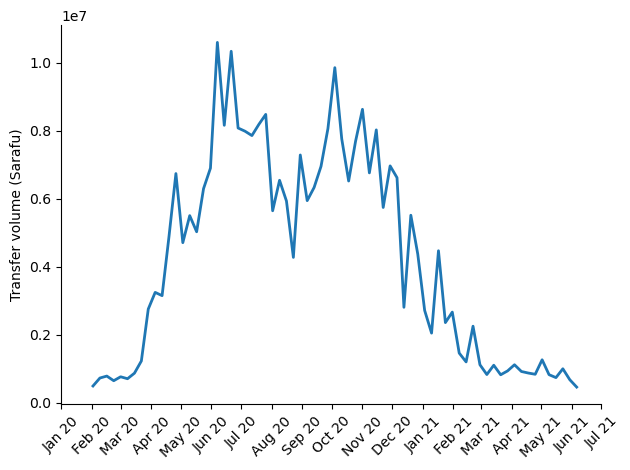

In [53]:
# transaction volumes
filepath = os.path.join(figsdir,"volume_weekly.pdf")
fig, ax = plt.subplots()
sns.lineplot(data=weekly_plot,
            x="week",
            y="volume",
            linewidth=2,
            ax=ax)
ax.set_ylabel("Transfer volume (Sarafu)")
#ax.set_ylim(0,25)
ax.set_xlim(plot_min,plot_max)
locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
fmt = mdates.DateFormatter('%b %y')
X = plt.gca().xaxis
X.set_major_locator(locator)
# Specify formatter
X.set_major_formatter(fmt)
ax.tick_params(axis='x', labelrotation=45)
ax.set_xlabel(None)
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig(filepath)
plt.show()

In [54]:
# Melt the volumes per area
tmp = weekly_plot[['week']+[term for term in weekly_plot.columns if 'volume:' in term]].melt(id_vars=['week'],value_name='volume')
tmp['Area of Kenya'] = tmp['variable'].str.replace('volume: ','').astype(area_cat)

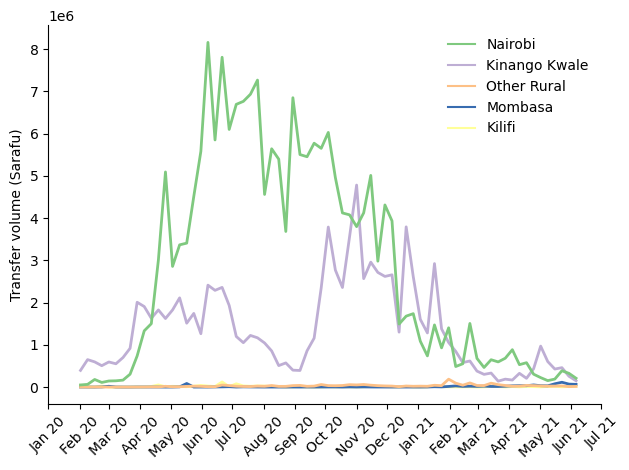

In [55]:
# transaction volumes
filepath = os.path.join(figsdir,"volume_weekly_area.pdf")
fig, ax = plt.subplots()
sns.lineplot(data=tmp,
            x="week",
            y="volume",
            linewidth=2,
            hue='Area of Kenya',
            palette=mod_Accent,
            ax=ax)
ax.set_ylabel("Transfer volume (Sarafu)")
#ax.set_ylim(0,25)
ax.set_xlim(plot_min,plot_max)
locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
fmt = mdates.DateFormatter('%b %y')
X = plt.gca().xaxis
X.set_major_locator(locator)
# Specify formatter
X.set_major_formatter(fmt)
ax.tick_params(axis='x', labelrotation=45)
ax.set_xlabel(None)
# Update the legend (https://stackoverflow.com/questions/71580424/add-custom-elements-to-sns-kdeplot-legend)
handles = ax.legend_.legend_handles
for h, t in zip(handles, ax.legend_.texts):
    h.set_label(t.get_text())  # assign the legend labels to the handles
ax.legend(handles=list(reversed(handles)), loc="upper right",frameon=False)
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig(filepath)
plt.show()

##### Total balance

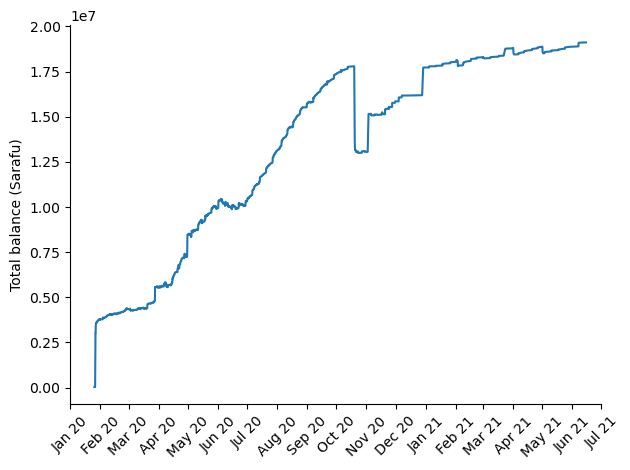

In [56]:
# nominal balance
filepath = os.path.join(figsdir,"balance_hourly.pdf")
fig, ax = plt.subplots()
sns.lineplot(data=hourly,
            x="hour",
            y="balance",
            ax=ax)
ax.set_ylabel("Total balance (Sarafu)")
#ax.set_ylim(0,25)
ax.set_xlim(plot_min,plot_max)
# Set the locator
locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
fmt = mdates.DateFormatter('%b %y')
X = plt.gca().xaxis
X.set_major_locator(locator)
# Specify formatter
X.set_major_formatter(fmt)
ax.tick_params(axis='x', labelrotation=45)
ax.set_xlabel(None)
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig(filepath)
plt.show()

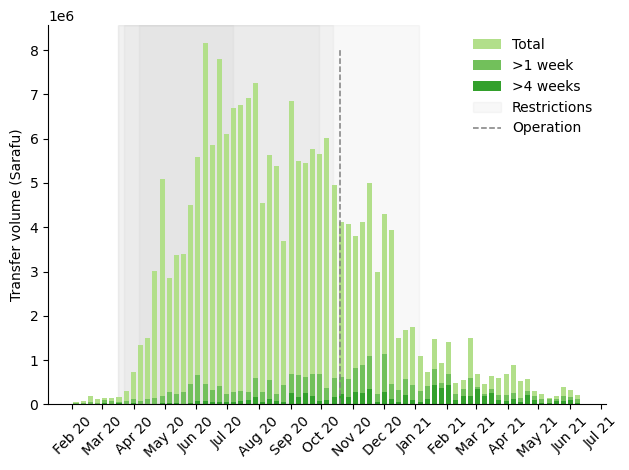

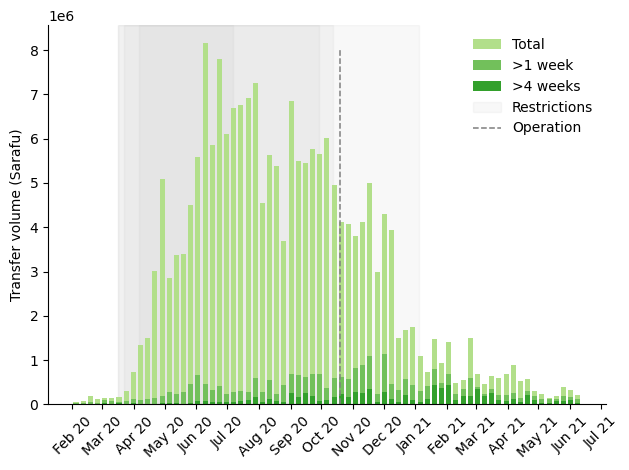

In [57]:
### Nairobi

for bound in ["min","max"]:

    # Transfer volume at different 'ages' of the money spent
    filepath = os.path.join(figsdir,"volume_weekly_duration_Nb_"+bound+".pdf")
    fig, ax = plt.subplots()

    # Specify the format - %b gives us Jan, Feb...
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))

    # Add shading for partial school closures, full school closures, bar closures, and lockdowns
    ax.axvspan(datetime(2020,3,16), datetime(2021,1,4), alpha=0.05, color='grey',label="Restrictions")   # partial school closures
    ax.axvspan(datetime(2020,3,16), datetime(2020,10,12), alpha=0.05, color='grey') # full school closures
    ax.axvspan(datetime(2020,3,22), datetime(2020,9,29), alpha=0.05, color='grey')  # bar closures
    ax.axvspan(datetime(2020,4,6), datetime(2020,7,7), alpha=0.05, color='grey')    # cessation of movement

    # Transaction volumes
    palete_Nb = [sns.color_palette("Paired")[3]]+[tuple(np.mean([sns.color_palette("Paired")[2],sns.color_palette("Paired")[3]],axis=0))]+[sns.color_palette("Paired")[2]]
    ax.bar(weekly_plot["week"],weekly_plot["volume: Nairobi"],label="Total",align='edge',width=5,color=palete_Nb[2])
    ax.bar(weekly_plot["week"],weekly_plot["volume>1wk_"+bound+": Nairobi"],label=">1 week",align='edge',width=5,color=palete_Nb[1])
    ax.bar(weekly_plot["week"],weekly_plot["volume>4wk_"+bound+": Nairobi"],label=">4 weeks",align='edge',width=5,color=palete_Nb[0])

    # Plot a vertical line at the date of the major reclamation
    ax.vlines(datetime(2020,10,19),0,8.0*10**6,label='Operation',colors='tab:grey',linestyles='dashed',linewidth=1.1)

    # Legend
    handles, labels = ax.get_legend_handles_labels()
    order = [2,3,4,0,1]
    ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],frameon=False)

    locator = mdates.MonthLocator()  # every month
    # Axes
    ax.set_ylabel("Transfer volume (Sarafu)")
    ax.tick_params(axis='x', labelrotation=45)
    ax.set_xlabel(None)
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tight_layout()
    plt.savefig(filepath)
    plt.show()

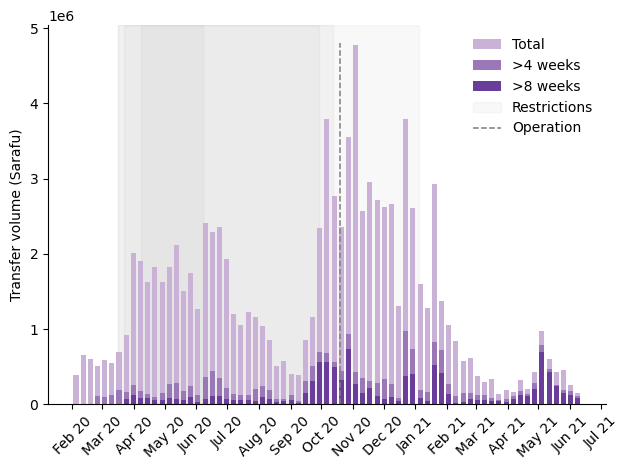

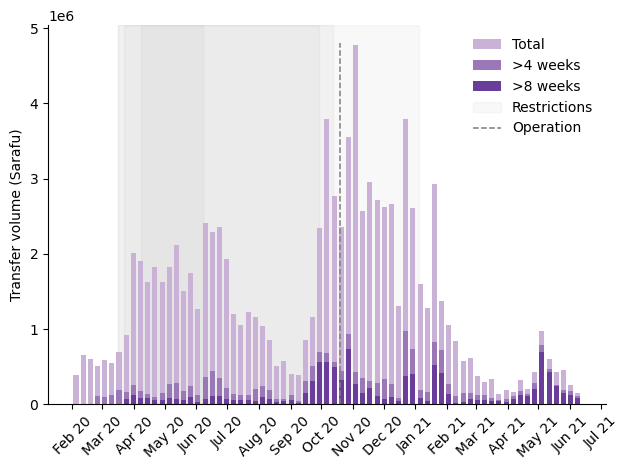

In [58]:
### Kinango Kwale

for bound in ["min","max"]:

    # Transfer volume at different 'ages' of the money spent
    filepath = os.path.join(figsdir,"volume_weekly_duration_KK_"+bound+".pdf")
    fig, ax = plt.subplots()

    # Specify the format - %b gives us Jan, Feb...
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))

    # Add shading for partial school closures, full school closures, bar closures, and lockdowns (slightly different)
    ax.axvspan(datetime(2020,3,16), datetime(2021,1,4), alpha=0.05, color='grey',label="Restrictions")   # partial school closures
    ax.axvspan(datetime(2020,3,16), datetime(2020,10,12), alpha=0.05, color='grey') # full school closures
    ax.axvspan(datetime(2020,3,22), datetime(2020,9,29), alpha=0.05, color='grey')  # bar closures
    ax.axvspan(datetime(2020,4,8), datetime(2020,6,7), alpha=0.05, color='grey')    # cessation of movement

    # Transaction volumes
    palete_KK = [sns.color_palette("Paired")[9]]+[tuple(np.mean([sns.color_palette("Paired")[8],sns.color_palette("Paired")[9]],axis=0))]+[sns.color_palette("Paired")[8]]
    ax.bar(weekly_plot["week"],weekly_plot["volume: Kinango Kwale"],label="Total",align='edge',width=5,color=palete_KK[2])
    ax.bar(weekly_plot["week"],weekly_plot["volume>4wk_"+bound+": Kinango Kwale"],label=">4 weeks",align='edge',width=5,color=palete_KK[1])
    ax.bar(weekly_plot["week"],weekly_plot["volume>8wk_"+bound+": Kinango Kwale"],label=">8 weeks",align='edge',width=5,color=palete_KK[0])

    # Plot a vertical line at the date of the major reclamation
    ax.vlines(datetime(2020,10,19),0,4.8*10**6,label='Operation',colors='tab:grey',linestyles='dashed',linewidth=1.1)

    # Legend
    handles, labels = ax.get_legend_handles_labels()
    order = [2,3,4,0,1]
    ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],frameon=False)

    locator = mdates.MonthLocator()  # every month
    # Axes
    ax.set_ylabel("Transfer volume (Sarafu)")
    ax.tick_params(axis='x', labelrotation=45)
    ax.set_xlabel(None)
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tight_layout()
    plt.savefig(filepath)
    plt.show()

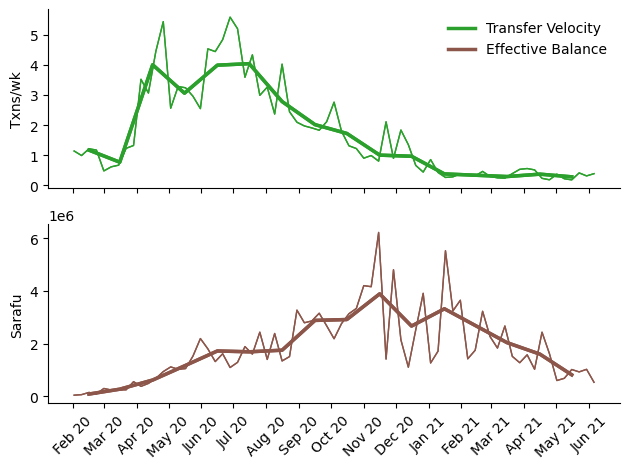

In [59]:
# inverse estimation: velocity & effective balance
filepath = os.path.join(figsdir,"velocity_inv_Nb.pdf")
fig, (ax, ax2) = plt.subplots(2, sharex=True)
sns.lineplot(data=weekly_plot,
            x="week",
            y="velocity_inv_min: Nairobi",
            linewidth=1,
            color=sns.color_palette()[2],
            ax=ax)
sns.lineplot(data=weekly_plot,
            x="week",
            y="velocity_inv_max: Nairobi",
            linewidth=1,
            color=sns.color_palette()[2],
            ax=ax)
sns.lineplot(data=monthly_plot,
            x="month",
            y="velocity_inv_min: Nairobi",
            linewidth=2.5,
            color=sns.color_palette()[2],
            ax=ax)
sns.lineplot(data=monthly_plot,
            x="month",
            y="velocity_inv_max: Nairobi",
            linewidth=2.5,
            color=sns.color_palette()[2],
            label="Transfer Velocity",
            ax=ax)
sns.lineplot(data=weekly_plot,
            x="week",
            y="balance_eff_min: Nairobi",
            linewidth=1,
            color=sns.color_palette()[5],
            ax=ax2)
sns.lineplot(data=weekly_plot,
            x="week",
            y="balance_eff_max: Nairobi",
            linewidth=1,
            color=sns.color_palette()[5],
            ax=ax2)
sns.lineplot(data=monthly_plot,
            x="month",
            y="balance_eff_min: Nairobi",
            linewidth=2.5,
            color=sns.color_palette()[5],
            ax=ax2)
sns.lineplot(data=monthly_plot,
            x="month",
            y="balance_eff_max: Nairobi",
            linewidth=2.5,
            color=sns.color_palette()[5],
            label="Effective Balance",
            ax=ax2)
# Legend
# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend([], [], loc=0, frameon=False)
ax.legend(lines + lines2, labels + labels2, loc=0, frameon=False)
# Axes
ax.set_ylabel("Txns/wk")
ax2.set_ylabel("Sarafu")
locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
fmt = mdates.DateFormatter('%b %y')
X = plt.gca().xaxis
X.set_major_locator(locator)
# Specify formatter
X.set_major_formatter(fmt)
ax2.tick_params(axis='x', labelrotation=45)
ax2.set_xlabel(None)
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig(filepath)
plt.show()

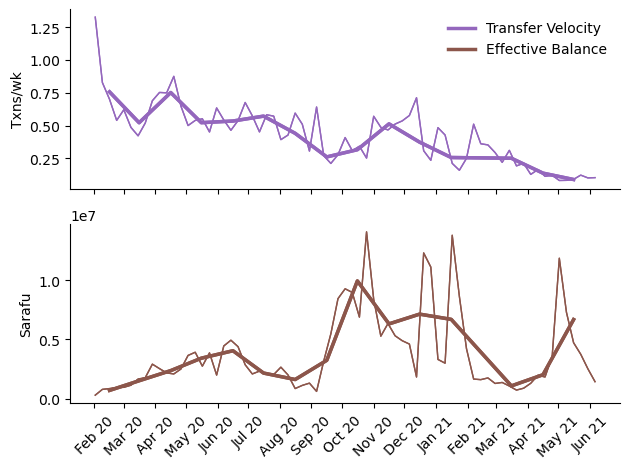

In [60]:
# inverse estimation: velocity & effective balance
filepath = os.path.join(figsdir,"velocity_inv_KK.pdf")
fig, (ax, ax2) = plt.subplots(2, sharex=True)
sns.lineplot(data=weekly_plot,
            x="week",
            y="velocity_inv_min: Kinango Kwale",
            linewidth=1,
            color=sns.color_palette()[4],
            ax=ax)
sns.lineplot(data=weekly_plot,
            x="week",
            y="velocity_inv_max: Kinango Kwale",
            linewidth=1,
            color=sns.color_palette()[4],
            ax=ax)
sns.lineplot(data=monthly_plot,
            x="month",
            y="velocity_inv_min: Kinango Kwale",
            linewidth=2.5,
            color=sns.color_palette()[4],
            ax=ax)
sns.lineplot(data=monthly_plot,
            x="month",
            y="velocity_inv_max: Kinango Kwale",
            linewidth=2.5,
            color=sns.color_palette()[4],
            label="Transfer Velocity",
            ax=ax)
sns.lineplot(data=weekly_plot,
            x="week",
            y="balance_eff_min: Kinango Kwale",
            linewidth=1,
            color=sns.color_palette()[5],
            ax=ax2)
sns.lineplot(data=weekly_plot,
            x="week",
            y="balance_eff_max: Kinango Kwale",
            linewidth=1,
            color=sns.color_palette()[5],
            ax=ax2)
sns.lineplot(data=monthly_plot,
            x="month",
            y="balance_eff_min: Kinango Kwale",
            linewidth=2.5,
            color=sns.color_palette()[5],
            ax=ax2)
sns.lineplot(data=monthly_plot,
            x="month",
            y="balance_eff_max: Kinango Kwale",
            linewidth=2.5,
            color=sns.color_palette()[5],
            label="Effective Balance",
            ax=ax2)
# Legend
# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend([], [], loc=0, frameon=False)
ax.legend(lines + lines2, labels + labels2, loc=0, frameon=False)
# Axes
ax.set_ylabel("Txns/wk")
ax2.set_ylabel("Sarafu")
locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
fmt = mdates.DateFormatter('%b %y')
X = plt.gca().xaxis
X.set_major_locator(locator)
# Specify formatter
X.set_major_formatter(fmt)
ax2.tick_params(axis='x', labelrotation=45)
ax2.set_xlabel(None)
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig(filepath)
plt.show()

## Holding time distributions

### Full distribution of durations, with precision and activity

In [61]:
# We'll need to filter out the handful of instantaneous durations that cannot be plotted on a log axis
zeros = {}
for bound in ["min","max"]:
    zeros[bound] = durations[bound][durations[bound]['duration']==0].index

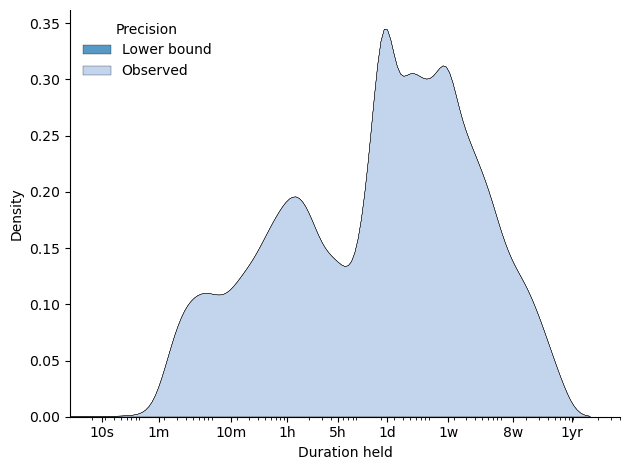

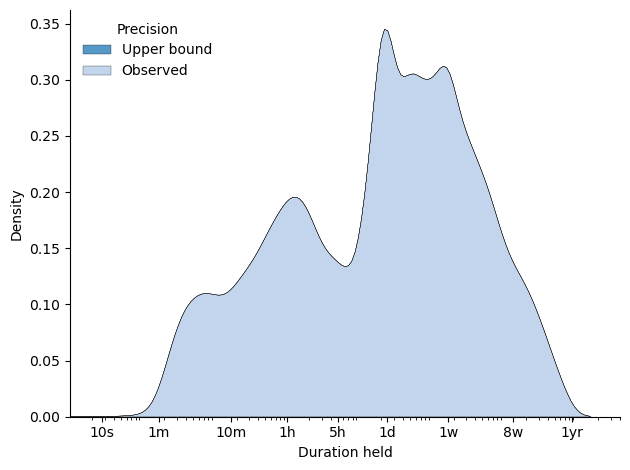

In [62]:
# Full distribution
for bound in ["min","max"]:
    filepath = os.path.join(figsdir,"durations_"+bound+".pdf")
    fig, ax = plt.subplots()
    sns.kdeplot(data=durations[bound].drop(zeros[bound]),
                x="duration",
                weights="amount",
                hue="Precision",
                palette="tab20",
                multiple='stack',
                linewidth=0.2,
                log_scale=True,
                ax=ax)
    sns.move_legend(ax, "upper left", frameon=False)
    ax.set_xlabel("Duration held")
    ax.set_xlim(0.001,40000)
    ax.set_xticks([1/60/6,1/60,1/6,1,5,24,7*24,8*7*24,365*24])
    ax.set_xticklabels(["10s","1m",'10m','1h','5h','1d','1w','8w','1yr'])
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tight_layout()
    plt.savefig(filepath)
    plt.show()

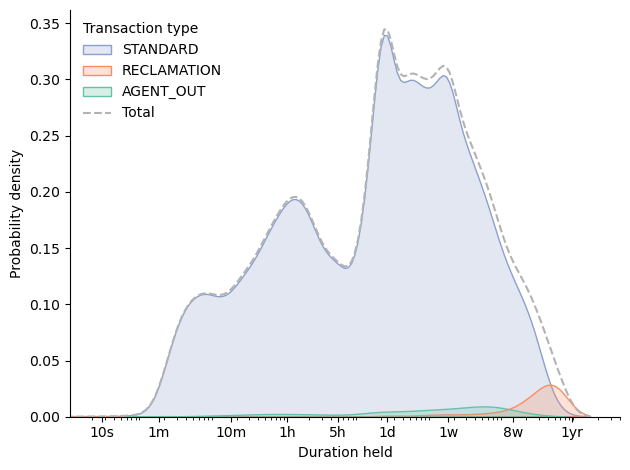

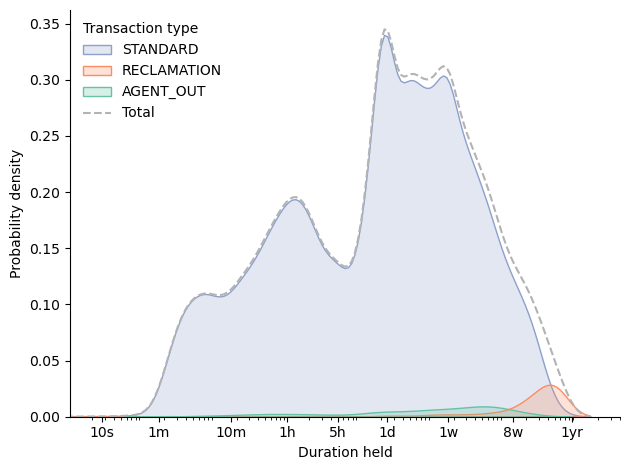

In [63]:
# Full distribution -- type
for bound in ["min","max"]:
    filepath = os.path.join(figsdir,"durations_type_"+bound+".pdf")
    fig, ax = plt.subplots()
    sns.kdeplot(data=durations[bound].drop(zeros[bound]),
                x="duration",
                weights="amount",
                color=sns.color_palette("Set2")[7],
                linestyle='--',
                log_scale=True,
                label="total",
                ax=ax)
    sns.kdeplot(data=durations[bound].drop(zeros[bound]),
                x="duration",
                weights="amount",
                hue="Type",
                palette="Set2",
                fill=True,
                log_scale=True,
                ax=ax)
    ax.set_ylabel("Probability density")
    ax.set_xlabel("Duration held")
    ax.set_xlim(0.001,40000)
    ax.set_xticks([1/60/6,1/60,1/6,1,5,24,7*24,8*7*24,365*24])
    ax.set_xticklabels(["10s","1m",'10m','1h','5h','1d','1w','8w','1yr'])
    # Update the legend (https://stackoverflow.com/questions/71580424/add-custom-elements-to-sns-kdeplot-legend)
    extra_legend_element = [
        Line2D([0], [0], color=sns.color_palette("Set2")[7], linestyle='--', label="Total")
    ]

    handles = ax.legend_.legend_handles
    for h, t in zip(handles, ax.legend_.texts):
        h.set_label(t.get_text())  # assign the legend labels to the handles
    leg = ax.legend(handles=list(reversed(handles))+extra_legend_element, loc="upper left",frameon=False, title="Transaction type")
    leg._legend_box.align = "left"
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tight_layout()
    plt.savefig(filepath)
    plt.show()

### Distribution of durations by type, by month, and by area of Kenya

In [64]:
# We'll need to filter out the handful of instantaneous durations that cannot be plotted on a log axis
zeros_trfs = {}
for bound in ["min","max"]:
    zeros_trfs[bound] = durations_trfs[bound][durations_trfs[bound]['duration']==0].index

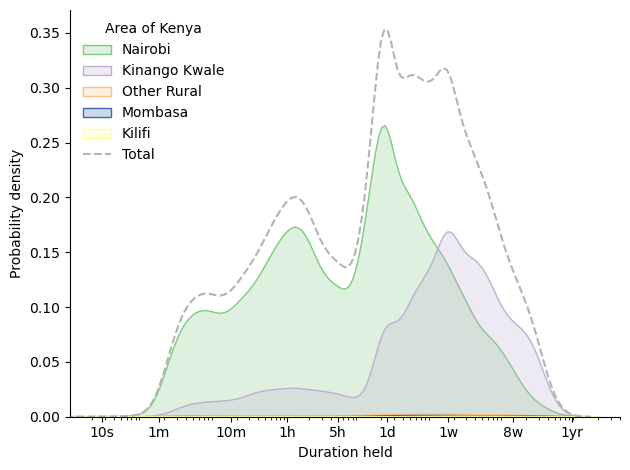

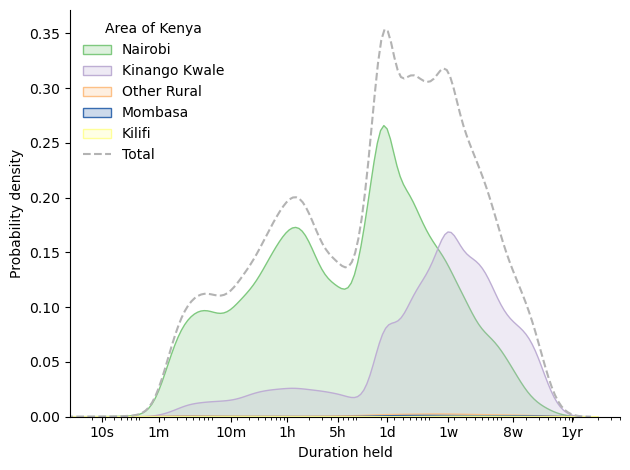

In [65]:
# Circulating funds -- geography
for bound in ["min","max"]:
    filepath = os.path.join(figsdir,"durations_area_"+bound+".pdf")
    fig, ax = plt.subplots()
    sns.kdeplot(data=durations_trfs[bound].drop(zeros_trfs[bound]),
                x="duration",
                weights="amount",
                color=sns.color_palette("Set2")[7],
                linestyle='--',
                log_scale=True,
                ax=ax)
    sns.kdeplot(data=durations_trfs[bound].drop(zeros_trfs[bound]),
                x="duration",
                weights="amount",
                hue="area_name",
                palette=mod_Accent,
                fill=True,
                log_scale=True,
                ax=ax)
    sns.move_legend(ax, "upper left", frameon=False, title=None)
    ax.set_ylabel("Probability density")
    ax.set_xlabel("Duration held")
    ax.set_xlim(0.001,40000)
    ax.set_xticks([1/60/6,1/60,1/6,1,5,24,7*24,8*7*24,365*24])
    ax.set_xticklabels(["10s","1m",'10m','1h','5h','1d','1w','8w','1yr'])
    # Update the legend (https://stackoverflow.com/questions/71580424/add-custom-elements-to-sns-kdeplot-legend)
    extra_legend_element = [
        Line2D([0], [0], color=sns.color_palette("Set2")[7], linestyle='--', label="Total")
    ]

    handles = ax.legend_.legend_handles
    for h, t in zip(handles, ax.legend_.texts):
        h.set_label(t.get_text())  # assign the legend labels to the handles
    ax.legend(handles=list(reversed(handles))+extra_legend_element, loc="upper left",frameon=False, title="Area of Kenya")
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tight_layout()
    plt.savefig(filepath)
    plt.show()

## Currency operation

On October 19, a fee was assessed on 31179 accounts. For most accounts, this served as a warning of upcoming regular demurrage charges; these began in November. However, long-inactive accounts were charged a substantial penalty. In many cases, this charge brought the balance of long-inactice accounts to zero. The total reclaimed over October 19/20 was 4,761,225 Sarafu---26.7% of the balance in the system at that point in time. 

This action was announced in advance, giving attentive Sarafu users a chance to spend their long-held funds.

#### Reclamation operation

In [66]:
# October 19-20 (processing 31179 reclamations took two days)
reclamations = txns[txns['transfer_subtype']=='RECLAMATION']
# drop transfers from the 'system' accounts
reclamations_sys = reclamations[reclamations['business_type']=='system'].index
reclamations = reclamations.drop(reclamations_sys)
# focus in on these particular days 
operation = reclamations[(reclamations['timeset']>'2020-10-19') & (reclamations['timeset']<'2020-10-21')]

In [67]:
# Amount reclaimed
print("Total", "\t\t", operation['weight'].sum(), operation['weight'].sum()/reclamations['weight'].sum())
print("Nairobi", "\t", operation[operation['area_name']=="Nairobi"]['weight'].sum())
print("Kinango Kwale", "\t", operation[operation['area_name']=="Kinango Kwale"]['weight'].sum())

Total 		 4759336.0 0.6617985803602711
Nairobi 	 2080601.0
Kinango Kwale 	 2248585.0


In [68]:
# Change in total balance
print("Total", "\t\t", hourly["balance"]["2020-10-19 00"],operation['weight'].sum()/hourly["balance"]["2020-10-19 00"])
print("Nairobi", "\t", hourly["balance: Nairobi"]["2020-10-19 00"],operation[operation['area_name']=="Nairobi"]['weight'].sum()/hourly["balance: Nairobi"]["2020-10-19 00"])
print("Kinango Kwale", "\t", hourly["balance: Kinango Kwale"]["2020-10-19 00"], operation[operation['area_name']=="Kinango Kwale"]['weight'].sum()/hourly["balance: Kinango Kwale"]["2020-10-19 00"])

Total 		 17792202.019077096 0.2674956138029998
Nairobi 	 7612514.293126335 0.2733132470934949
Kinango Kwale 	 9330945.337971456 0.2409814781412964


In [69]:
# Durations held prior to funds being reclaimed; we use the upper bound so that we can include the untracked durations that end with this reclamation
operation_durs = durations["max"][durations["max"]['motif'].str.contains('RECLAMATION')]
operation_durs = operation_durs[(operation_durs['timestamp_end']>'2020-10-19') & (operation_durs['timestamp_end']<'2020-10-21')]
# ignore the ones starting from funds left untracked because they became too small
operation_durs = operation_durs[operation_durs['timestamp_beg']>'2020-01-25']

In [70]:
# Comparison
operation_comp = operation.groupby("area_name").agg({"weight":sum}).rename(columns={"weight":"op_txns"})
operation_comp["op_durs"] = operation_durs.groupby("area_name").agg({"amount":sum})["amount"]
operation_comp["op_diff"] = operation_comp["op_txns"] - operation_comp["op_durs"]
operation_comp

,op_txns,op_durs,op_diff
area_name,,,
Kilifi,106245.0,1.062449e+05,0.100256
Kinango Kwale,2248585.0,2.248575e+06,10.080077
Mombasa,153059.0,1.530590e+05,0.000006
Nairobi,2080601.0,2.080592e+06,8.983104
Other Rural,170846.0,1.708459e+05,0.149733


WOW! Using 0.01 Sarafu as our limit we miss only ~20 Sarafu, or 0.0004% of these reclaimed funds. So even with the imprecision that tracing introduces, our understanding remains almost perfect. We know how and when these long-held funds entered these accounts, under the well-mixed heuristic. 

#### Affected accounts

In [71]:
# drop transfers from the 'system' accounts
users_sys = users[users['business_type']=='system'].index
users_tmp = users.drop(users_sys)

In [72]:
# Accounts affected
print("Area", "\t\t", "affected", "\t", "ever active", "\t", "registered")
print("Total", "\t\t", len(operation['source'].unique()), "\t\t", len(trfs['source'].unique()),"\t\t",len(users_tmp))
print("Nairobi", "\t", len(operation[operation['area_name']=="Nairobi"]['source'].unique()),"\t\t", len(trfs[trfs['area_name']=="Nairobi"]['source'].unique()),"\t\t", len(users_tmp[users_tmp['area_name']=="Nairobi"]))
print("Kinango Kwale", "\t", len(operation[operation['area_name']=="Kinango Kwale"]['source'].unique()), "\t\t",len(trfs[trfs['area_name']=="Kinango Kwale"]['source'].unique()),"\t\t",len(users[users['area_name']=="Kinango Kwale"]))

Area 		 affected 	 ever active 	 registered
Total 		 31168 		 39197 		 54958
Nairobi 	 11150 		 11002 		 15364
Kinango Kwale 	 17411 		 19533 		 23671


In [73]:
# Never-active accounts
inactive = set(users_tmp.index) - set(trfs['source'].unique())
print("Total", "\t\t", operation[operation['source'].isin(inactive)]['weight'].sum())
tmp = operation[(operation['source'].isin(inactive)) & (operation['area_name']=="Nairobi")]['weight'].sum()
print("Nairobi", "\t", tmp, "\t", tmp/operation[operation['area_name']=="Nairobi"]['weight'].sum())
tmp = operation[(operation['source'].isin(inactive)) & (operation['area_name']=="Kinango Kwale")]['weight'].sum()
print("Kinango Kwale", "\t", tmp, "\t", tmp/operation[operation['area_name']=="Kinango Kwale"]['weight'].sum())

Total 		 2274530.0
Nairobi 	 1090510.0 	 0.5241322098758965
Kinango Kwale 	 850060.0 	 0.37804219097788166


In [74]:
# What fraction of affected accounts were never active?
len(inactive & set(operation[operation['area_name']=="Nairobi"]['source'].unique()))/len(operation[operation['area_name']=="Nairobi"]['source'].unique())

0.35623318385650227

In [75]:
# What fraction of affected accounts were never active?
len(inactive & set(operation[operation['area_name']=="Kinango Kwale"]['source'].unique()))/len(operation[operation['area_name']=="Kinango Kwale"]['source'].unique())

0.22181379587617023

#### Age profile of the dissolved balance

In [76]:
# Average age (in weeks)
def average_age(df):
    return (df['amount']*df['duration']).sum()/df['amount'].sum()/24/7

In [77]:
# Some nice little stats:
print("Total")
total = operation_durs['amount'].sum()
exiting = operation_durs[operation_durs['categ'].isin(["transfer~withdraw","existing~withdraw"])]
static = operation_durs[operation_durs['categ'].isin(["deposit~withdraw"])]
print("Had     entered circulation:",exiting['amount'].sum(),'\t',exiting['amount'].sum()/total)
print("Had not entered circulation:",static['amount'].sum(),'\t',static['amount'].sum()/total)
print("                           , average age:",average_age(operation_durs),"weeks")
print("Had     entered circulation, average age:",average_age(exiting),"weeks")
print("Had not entered circulation, average age:",average_age(static),"weeks")
# Now for some meaningful week cutoffs:
for weeks in [52,26,13,8,4,1]:
    weeks_old = operation_durs[operation_durs['duration']>weeks*7*24]['amount'].sum()
    print("Was more than "+str(weeks).rjust(2)+" weeks old:",weeks_old,'\t',weeks_old/total)

Total
Had     entered circulation: 484137.516779 	 0.1017241651767611
Had not entered circulation: 4275179.1700450005 	 0.8982758348232389
                           , average age: 25.128963747099586 weeks
Had     entered circulation, average age: 18.958149400768725 weeks
Had not entered circulation, average age: 25.827770186621375 weeks
Was more than 52 weeks old: 0.0 	 0.0
Was more than 26 weeks old: 1889044.2732539999 	 0.396915019016018
Was more than 13 weeks old: 4161315.0770280003 	 0.8743513724456399
Was more than  8 weeks old: 4517174.81708 	 0.9491225556781373
Was more than  4 weeks old: 4674335.093917999 	 0.9821441609167826
Was more than  1 weeks old: 4747920.336424 	 0.9976054649963615


In [78]:
# Some nice little stats:
for area in ["Nairobi","Kinango Kwale"]:
    print(area)
    # dataframes
    operation_tmp = operation_durs[operation_durs["area_name"]==area]
    exiting = operation_tmp[operation_tmp['categ'].isin(["transfer~withdraw","existing~withdraw"])]
    static = operation_tmp[operation_tmp['categ'].isin(["deposit~withdraw"])]
    # total
    total = operation_tmp['amount'].sum()
    print("Had     entered circulation:",exiting['amount'].sum(),'\t',exiting['amount'].sum()/total)
    print("Had not entered circulation:",static['amount'].sum(),'\t',static['amount'].sum()/total)
    print("                           , average age:",average_age(operation_tmp),"weeks")
    print("Had     entered circulation, average age:",average_age(exiting),"weeks")
    print("Had not entered circulation, average age:",average_age(static),"weeks")
    # Now for some meaningful week cutoffs:
    for weeks in [52,26,13,8,4,1]:
        weeks_old = operation_tmp[operation_tmp['duration']>weeks*7*24]['amount'].sum()
        print("Was more than "+str(weeks).rjust(2)+" weeks old:",weeks_old,'\t',weeks_old/total)
    print("")

Nairobi
Had     entered circulation: 268601.334657 	 0.12909851257514762
Had not entered circulation: 1811990.682239 	 0.8709014874248523
                           , average age: 24.610187764811634 weeks
Had     entered circulation, average age: 19.402624873796054 weeks
Had not entered circulation, average age: 25.382133424658345 weeks
Was more than 52 weeks old: 0.0 	 0.0
Was more than 26 weeks old: 788146.487979 	 0.378808762880299
Was more than 13 weeks old: 1767154.568775 	 0.8493517971925068
Was more than  8 weeks old: 1949008.997664 	 0.9367569335249557
Was more than  4 weeks old: 2028686.143433 	 0.9750523538293502
Was more than  1 weeks old: 2077322.116341 	 0.9984283797455503

Kinango Kwale
Had     entered circulation: 200286.360541 	 0.08907257604201091
Had not entered circulation: 2048288.5593819998 	 0.910927423957989
                           , average age: 24.93286326137734 weeks
Had     entered circulation, average age: 18.153638667807382 weeks
Had not entered circulat